In [5]:
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from matplotlib import colors
from xhistogram.xarray import histogram
import util

from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

chunks = {"x":3000, "ncol":3000}

In [3]:
run = "dpscream_rce_large_3km_lpfrz300k_branch"
run_dir = f"/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/{run}/run/"
file = run_dir + f"{run}_h0_last5days"
qsmall=1e-8

In [4]:
plt.rcParams.update({'font.size': 18})  # all to 18 if not specified other

# plot one run micro-hist

In [4]:
####################################################################
# plot 1 run
####################################################################

file = run_dir + f"{run}_h0_last5days.nc"
print(file)
ds = xr.open_dataset(file, chunks=chunks)[["T","CLDICE","NUMICE","Q"]].isel(time=slice(-16,-1))
# bcu = xr.open_dataset(run_dir+f"{run}_BCU_hrs.nc", chunks=chunks)['BCU'].sel(time=ds.time, method="nearest")
# nuc = xr.open_dataset(run_dir+f"{run}_NUC_hrs.nc", chunks=chunks)['NUC'].sel(time=ds.time, method="nearest")
print("getting t<-40 and cldice>qsmall...")
ds = ds.where((ds["T"]<233.15)&(ds.CLDICE>qsmall))
# nuc = nuc.where((ds["T"]<233.15)&(ds.CLDICE>qsmall))
# ds = ds.where((nuc==0))  # &(bcu<50))  # .compute()
print(ds.Q.shape)
ds.CLDICE

/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/dpscream_rce_large_3km_lsascent304k_branch/run/dpscream_rce_large_3km_lsascent304k_branch_h0_last5days.nc
getting t<-40 and cldice>qsmall...
(15, 128, 147456)


<xarray.DataArray 'CLDICE' (time: 15, lev: 128, ncol: 147456)>
dask.array<where, shape=(15, 128, 147456), dtype=float32, chunksize=(15, 128, 2000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2000-02-26 06:00:00 ... 2000-03-01 18:00:00
  * lev      (lev) float64 2.58 3.23 3.88 4.597 ... 987.2 991.0 994.9 998.5
Dimensions without coordinates: ncol
Attributes:
    long_name:     Grid box averaged cloud ice amount
    units:         kg/kg
    mdims:         1
    mixing_ratio:  wet
    cell_methods:  time: point

In [5]:
print("calc Rice...")
# x_array = np.cbrt(3*ds.CLDICE/(4*np.pi*920.0*ds.NUMICE))
# x_array = x_array * 1e6
x_array = util.calc_rice(ds.CLDICE, ds.NUMICE)
print(x_array.shape)


calc Rice...
(15, 128, 147456)


In [7]:
print("calc NI...")
y_array = util.calc_ni(ds.NUMICE, ds.Q, ds.lev*100, ds["T"])
print(y_array.shape)

calc NI...
(15, 128, 147456)


In [9]:
del ds

In [10]:
print("flattening...")
x_array = x_array.values.flatten()
print("x done...")

n = len(x_array)
y_array = y_array.values.flatten()/1e6  # convert to cm-3
print("y done...")
# # z_array = nuc.values.flatten()
# print(x_array.shape, y_array.shape)  # , z_array.shape)
# x_array = x_array[~np.isnan(y_array)]
# y_array = y_array[~np.isnan(y_array)]
# # z_array = z_array[~np.isnan(z_array)]
# print(x_array.shape, y_array.shape, n)  # , z_array.shape, n)

flattening...
[########################################] | 100% Completed | 220.74 s
x done...
[########################################] | 100% Completed | 280.63 s
y done...


In [11]:
xbins=np.linspace(0,100,100)
ybins=np.logspace(-5,2,70)
stat='count'

hist, xbins, ybins, _ = stats.binned_statistic_2d(x_array, y_array, None,
                                                  statistic=stat,
                                                  bins=[xbins,ybins])
print("got count...")
hist = np.where(hist>0,hist,np.nan)
print("got non-zero values...")
hist = hist/n
print("normalized...")
print(np.nansum(hist),stat,end="")

xbins = (xbins[1:]+xbins[:-1])/2
ybins = (ybins[1:]+ybins[:-1])/2

got count...
got non-zero values...
normalized...
0.0659685558742947 count

In [12]:
# xbins=np.linspace(0,100,100)
# ybins=np.logspace(-5,2,70)
# stat='count'

In [13]:
# x_array = xr.DataArray(x_array, dims=x_array.dims, name="Rice")
# y_array = xr.DataArray(y_array, dims=y_array.dims, name="ICNC")

In [14]:
x_array

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

plotting... 

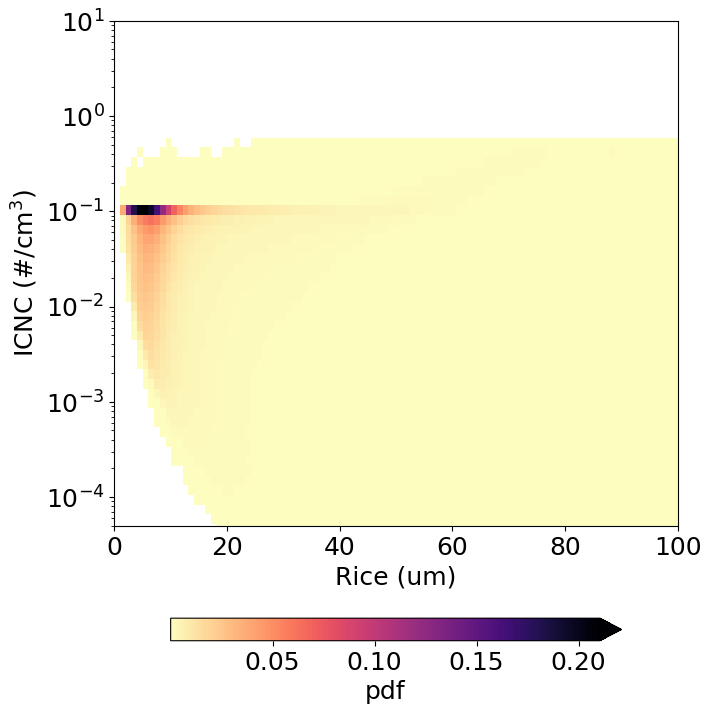

In [15]:
print("plotting... ", end="")
fig, ax = plt.subplots(1, 1, figsize=(7,7), constrained_layout=True)
# weights = xr.ones_like(x_array) / np.prod(x_array.shape) * 100
# cf = histogram(x_array, y_array/1e6, bins=[xbins,ybins],
#                weights=weights, dim=['time','lev','x']).plot.pcolormesh(ax=ax)
cf = ax.pcolormesh(xbins, ybins, (hist*100).T, cmap="magma_r",
                      shading='auto',
                      # levels=[0,1,2,4,8,16,32,48]
                      # vmin = 0, vmax=0.05 #0.02, 0.3 std
                     )
ax.set(yscale='log')
ax.set(xlim=[0,100], ylim=[5e-5,10])
ax.set(ylabel="ICNC (#/cm$^3$)", xlabel="Rice (um)")
plt.colorbar(cf, ax=ax, label=f"pdf", location="bottom", shrink=0.8, extend='max')
plt.savefig("../plots/large/micro_hist_run_{}_{}.png".format(run, stat), dpi=120)
plt.show()

# plot w and ni tracers as mean values in this phase space

In [17]:
file = run_dir + f"{run}_h0_last5days.nc"
var="W_NUC"
var_file = run_dir+f"{run}_{var}_hrs.nc"
print(file, var_file)
ds = xr.open_dataset(file, chunks=chunks)[["T","CLDICE","NUMICE","Q"]].isel(time=slice(-10,-1))
nuc = xr.open_dataset(run_dir+f"{run}_NUC_hrs.nc")['NUC'].isel(time=slice(-10,-1))
var_ds = xr.open_dataset(var_file)[var].isel(time=slice(-10,-1))
print("getting t<-40 and cldice>qsmall...")
ds = ds.where((ds["T"]<233.15)&(ds.CLDICE>qsmall))
var_ds = var_ds.where((ds["T"]<233.15)&(ds.CLDICE>qsmall))
var_ds = var_ds.where(nuc<6)
var_ds = var_ds.compute()
print("done.", var_ds.shape)
var_ds

/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/dpscream_rce_large_3km_lpfrz300k_branch/run/dpscream_rce_large_3km_lpfrz300k_branch_h0_last5days.nc /glade/derecho/scratch/sturbeville/DPSCREAM_simulations/dpscream_rce_large_3km_lpfrz300k_branch/run/dpscream_rce_large_3km_lpfrz300k_branch_W_NUC_hrs.nc
getting t<-40 and cldice>qsmall...
[########################################] | 100% Completed | 171.94 s
[########################################] | 100% Completed | 171.96 s
done. (9, 128, 147456)


<xarray.DataArray 'W_NUC' (time: 9, lev: 128, ncol: 147456)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) object 2000-02-27 18:00:00 ... 2000-03-01 18:00:00
  * lev      (lev) float64 2.58 3.23 3.88 4.597 ... 987.2 991.0 994.9 998.5
Dimensions without coordinates: ncol
Attributes:
    long_name:     W at nucleation
    units:         kg/kg
    mdims:         1
    mixing_ratio:  dry
    cell_methods:  time: point

In [18]:
var_ds.max().values

array(7.84557772)

In [ ]:
hist, edges = np.histogram(var_ds.values.flatten(), bins=-np.logspace(-4,1,20))
hist

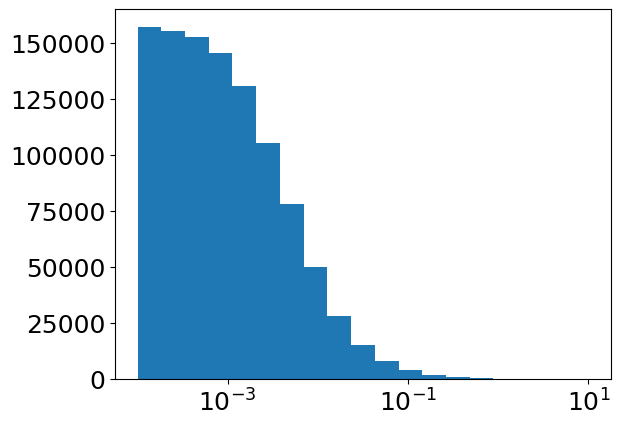

In [35]:
fig, ax = plt.subplots(1,1)
ax.bar(edges[:-1], hist, align='edge', width=(edges[1:]-edges[:-1]))
ax.set(xscale='log', 
       # yscale='log',
       # ylim=[1,1e4],
      )
plt.show()